In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount= True)

Mounted at /content/gdrive


In [ ]:
%cd

/root


In [ ]:
import os
from PIL import Image
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use ('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

Data Preprocessing

In [ ]:
data = []
paths = []
result = []

for r, d, f in os.walk(r'/content/gdrive/MyDrive/Tumor Detection/brain_tumor_dataset/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())
result[0]        

array([[1., 0.]])

In [ ]:
paths = []
for r, d, f in os.walk(r"/content/gdrive/MyDrive/Tumor Detection/brain_tumor_dataset/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [ ]:
data = np.array(data)
data.shape

(139, 128, 128, 3)

In [ ]:
result = np.array(result)
result = result.reshape(139,2)
result.shape

(139, 2)

Train & Test 

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(data, result, test_size=0.1, shuffle=True, random_state=1)

In [ ]:
print('Train Images Shape', train_images.shape)
print('Train Labels Shape', train_labels.shape)
print('Test Images Shape', test_images.shape)
print('Test Labels Shape', test_labels.shape)

Train Images Shape (125, 128, 128, 3)
Train Labels Shape (125, 2)
Test Images Shape (14, 128, 128, 3)
Test Labels Shape (14, 2)


Create model with fuctional API

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))

conv2d_layer = tf.keras.layers.Conv2D(32, (2,2), padding='Same')(inputs)
conv2d_layer = tf.keras.layers.Conv2D(32, (2,2), activation='relu', padding='Same')(conv2d_layer)

bn_layer = tf.keras.layers.BatchNormalization()(conv2d_layer)
mp_layer = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(bn_layer)
drop = tf.keras.layers.Dropout(0.25)(mp_layer)

conv2d_layer = tf.keras.layers.Conv2D(64, (2,2), activation='relu', padding='Same')(drop)
conv2d_layer = tf.keras.layers.Conv2D(64, (2,2), activation='relu', padding='Same')(conv2d_layer)

bn_layer = tf.keras.layers.BatchNormalization()(conv2d_layer)
mp_layer = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(bn_layer)
drop = tf.keras.layers.Dropout(0.25)(mp_layer)

flatten_layer = tf.keras.layers.Flatten()(drop)

dense_layer = tf.keras.layers.Dense(512, activation='relu')(flatten_layer)
drop = tf.keras.layers.Dropout(0.5)(dense_layer)
outputs = tf.keras.layers.Dense(2, activation='softmax')(drop)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='tumor_model')
model.summary()

Model: "tumor_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4128      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        

Fit model

In [ ]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adamax(),
             metrics = ['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels,
                   epochs=40,
                   batch_size=128,
                   validation_data=(test_images, test_labels))

Epoch 1/40
1/1 [==============================] - 8s 8s/step - loss: 1.8656 - accuracy: 0.5280 - val_loss: 185.2887 - val_accuracy: 0.6429
Epoch 2/40
1/1 [==============================] - 6s 6s/step - loss: 44.6775 - accuracy: 0.6560 - val_loss: 39.2576 - val_accuracy: 0.7857
Epoch 3/40
1/1 [==============================] - 6s 6s/step - loss: 24.9348 - accuracy: 0.6800 - val_loss: 44.3085 - val_accuracy: 0.5714
Epoch 4/40
1/1 [==============================] - 6s 6s/step - loss: 20.9923 - accuracy: 0.6640 - val_loss: 22.2333 - val_accuracy: 0.6429
Epoch 5/40
1/1 [==============================] - 6s 6s/step - loss: 9.7335 - accuracy: 0.7200 - val_loss: 8.8144 - val_accuracy: 0.7857
Epoch 6/40
1/1 [==============================] - 6s 6s/step - loss: 2.9338 - accuracy: 0.8480 - val_loss: 17.3916 - val_accuracy: 0.7857
Epoch 7/40
1/1 [==============================] - 6s 6s/step - loss: 2.8708 - accuracy: 0.8720 - val_loss: 20.6073 - val_accuracy: 0.7857
Epoch 8/40
1/1 [===============

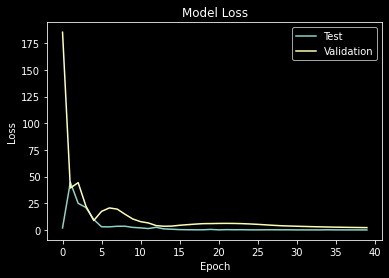

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

In [ ]:
def names(number):
    if number==0:
        return 'it is a Tumor'
    else:
        return 'No, it is not a tumor'

99.67398047447205% Confidence it is a Tumor


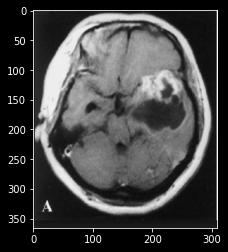

In [ ]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/gdrive/MyDrive/Tumor Detection/brain_tumor_dataset/yes/Y112.JPG")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence ' + names(classification))

99.99991655349731% Confidence No, it is not a tumor


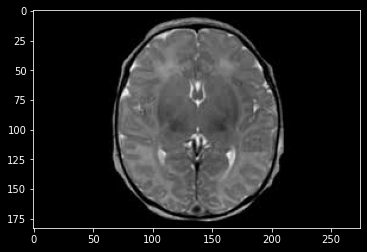

In [ ]:
img = Image.open(r"/content/gdrive/MyDrive/Tumor Detection/brain_tumor_dataset/no/12 no.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence ' + names(classification))